In [1]:
import numpy as np
import pickle
import itertools
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torchvision import transforms
from SegDataset import SegmentationDataset
from einops import rearrange
from transformers import AdamW, SegformerForSemanticSegmentation
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.data import DataLoader

/home/mpham/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

Config

In [3]:
DATASET_DIRECTORY = "ml-mangrove-data/"
#PRETRAINED_MODEL_NAME = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024" #alternative pretrained_model_name = "nvidia/mit-b5"
PRETRAINED_MODEL_NAME ="./segformer-b5-finetuned-mangrove-128-128/" 


DEVICE = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for training and evaluation
PIN_MEMORY = True if DEVICE == "cuda" else False #if we will be pinning memory during data loading

INPUT_IMAGE_WIDTH = 128 #or 256
INPUT_IMAGE_HEIGHT = 128
NUM_CHANNELS = 9
NUM_CLASSES = 1

TEST_SPLIT = 0.10
BATCH_SIZE = 32
INIT_LR = 0.0001 #0.0001 #0.00006
NUM_EPOCHS = 20
TEST_EVAL_EVERY_BATCH = 15 #how frequently to compute/save/display test accuracy, must be non-zero positive

EARLY_STOPPER_PATIENCE = 1 #how many epochs of lower test set accuracy before early stopping (also dependent on delta)
EARLY_STOPPER_DELTA = 0 #how much test set accuracy needs to drop before early stopping (also dependent on patience)

# THRESHOLD = 0.5 # define threshold to filter weak predictions
# BASE_OUTPUT = "output" # define the path to the base output directory

# define the path to the output serialized model, model training
# plot, and testing image paths
# MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_mangrove.pth")
# PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

Read Files

In [4]:
#read data from https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle
with open(DATASET_DIRECTORY + '128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open(DATASET_DIRECTORY + '128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open(DATASET_DIRECTORY + '128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

Data Preprocessing

In [5]:
#rearrange dimensions of images and labels
images = np.array(images)
images = rearrange(images, "b w h c -> b c w h")

labels = np.array(labels)
labels = rearrange(labels, "b w h c -> b c w h")
labels = np.squeeze(labels, axis=1)

print(f'input shape (b x c x w x h): {images.shape}')
print(f'label shape (b x [squeezed 1 channel] x w x h): {labels.shape}')

input shape (b x c x w x h): (4092, 9, 128, 128)
label shape (b x [squeezed 1 channel] x w x h): (4092, 128, 128)


In [6]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
trainImages, testImages, trainMasks, testMasks = train_test_split(images, labels, #images, labels,
                         test_size=TEST_SPLIT, random_state=42)
# unpack the data split
# (trainImages, testImages) = split[:2]
# (trainMasks, testMasks) = split[2:]
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = transforms)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = transforms)
                             #transforms=transforms)
print(f"found {len(trainDS)} examples in the training set.")
print(f"found {len(testDS)} examples in the test set.")
# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=0) #os.cpu_count()
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=0) #os.cpu_count()

found 3682 examples in the training set.
found 410 examples in the test set.


In [7]:
# assign the human-readable labels to encoding, encoding to human-readable labels
id2label = {
    0: "nomangrove",
    1: "mangrove"
}

label2id = {
    "nomangrove": 0,
    "mangrove": 1
}

Initialize Model

In [8]:
# Load the pretrained model
model = SegformerForSemanticSegmentation.from_pretrained(
    PRETRAINED_MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    num_labels = 2
)

# Modify the first layer to match the number of channels in data
modified_layer = nn.Conv2d(NUM_CHANNELS, 64, kernel_size=7, stride=4, padding=3)
model.segformer.encoder.patch_embeddings[0].proj = modified_layer

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at ./segformer-b5-finetuned-mangrove-128-128/ and are newly initialized because the shapes did not match:
- segformer.encoder.patch_embeddings.0.proj.weight: found shape torch.Size([64, 9, 7, 7]) in the checkpoint and torch.Size([64, 3, 7, 7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
print(model)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(9, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [10]:
batch = next(iter(trainLoader))
test_batch = itertools.cycle(testLoader)

In [11]:
optimizer = AdamW(model.parameters(), lr=INIT_LR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


/home/mpham/.local/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train

In [12]:
class Early_stopper: #early stopper class -> move to py file
    def __init__(self):
        self.patience = EARLY_STOPPER_PATIENCE
        self.delta = EARLY_STOPPER_DELTA
        self.patience_counter = 0
        self.min_test_loss = np.inf
    def check_stop(self, test_loss):
        if self.min_test_loss > test_loss:
            self.patience_counter = 0
            self.min_test_loss = test_loss
        elif test_loss > (self.min_test_loss + self.delta):
            self.patience_counter += 1
            if self.patience_counter >= self.patience:
                return True
        return False

In [13]:
class Total_updater:
  def __init__(self):
    self.test_epoch = [] 
    self.test_acc = [] 
    self.test_avr_acc = [] 
    self.test_loss = [] 
    self.test_avr_loss = [] 
    self.test_avr_acc_epoch = []
    self.test_avr_loss_epoch = []
    self.tests_count = 0 
    self.tests_epoch_count = 0 

    self.train_epoch = []
    self.train_acc = []
    self.train_avr_acc = []
    self.train_loss = []
    self.train_avr_loss = []
    self.train_avr_acc_epoch = []
    self.train_avr_loss_epoch = []
    self.trains_count = 0
    self.trains_epoch_count = 0


    self.epoch_test_acc_cum = 0 #use
    self.total_test_acc_cum = 0 #use
    self.epoch_test_loss_cum = 0 #use
    self.total_test_loss_cum = 0 #use

    self.epoch_train_acc_cum = 0
    self.total_train_acc_cum = 0
    self.epoch_train_loss_cum = 0
    self.total_train_loss_cum = 0

    self.epoch = 0
  def update_test(self, acc, loss):
    self.tests_count += 1
    self.tests_epoch_count += 1
    self.test_epoch.append(self.epoch + TEST_EVAL_EVERY_BATCH * self.tests_epoch_count/(len(trainDS) // BATCH_SIZE + 1 ))#self.epoch + (self.tests_epoch_count-1)/self.tests_epoch_count)

    self.test_acc.append(acc)
    self.test_acc.append(loss)

    self.epoch_test_acc_cum += acc
    self.total_test_acc_cum += acc
    self.epoch_test_loss_cum += loss
    self.total_test_loss_cum += loss

    self.test_avr_acc.append(self.total_test_acc_cum/self.tests_count)
    self.test_avr_loss.append(self.total_test_loss_cum/self.tests_count)

  def update_train(self, acc, loss):
    self.trains_count += 1
    self.trains_epoch_count += 1
    self.train_epoch.append(self.epoch + self.trains_epoch_count/(len(trainDS) // BATCH_SIZE + 1 )) #(self.epoch + (self.trains_epoch_count-1)/self.trains_epoch_count)

    self.train_acc.append(acc)
    self.train_acc.append(loss)

    self.epoch_train_acc_cum += acc
    self.total_train_acc_cum += acc
    self.epoch_train_loss_cum += loss
    self.total_train_loss_cum += loss

    self.train_avr_acc.append(self.total_train_acc_cum/self.trains_count)
    self.train_avr_loss.append(self.total_train_loss_cum/self.trains_count)


  def reset_epoch(self):
    self.test_avr_acc_epoch.append(self.epoch_test_acc_cum/self.tests_epoch_count)
    self.test_avr_loss_epoch.append(self.epoch_test_loss_cum/self.tests_epoch_count)

    self.train_avr_acc_epoch.append(self.epoch_train_acc_cum/self.trains_epoch_count)
    self.train_avr_loss_epoch.append(self.epoch_train_loss_cum/self.trains_epoch_count)
    
    print(f"EPOCH {self.epoch} Avr Test Accuracy: {self.test_avr_acc_epoch[self.epoch]}\
         Avr Test Loss: {self.test_avr_loss_epoch[self.epoch]}\
         Avr Train Accuracy: {self.train_avr_acc_epoch[self.epoch]}\
         Avr Train Loss: {self.train_avr_loss_epoch[self.epoch]}")
    
    
    self.epoch_test_acc_cum = 0
    self.epoch_test_loss_cum = 0
    self.epoch_train_acc_cum = 0
    self.epoch_train_loss_cum = 0

    self.tests_epoch_count = 0
    self.trains_epoch_count = 0

    self.epoch += 1



In [14]:
# accuracies = []
# losses = []
# test_accuracies = []
# test_losses = []
# batch_index = 0
early_stopper = Early_stopper()
total_updater = Total_updater()

In [15]:
for epoch in range(NUM_EPOCHS):
    print("Epoch:", epoch)
    pbar = tqdm(trainLoader)
    model.train()
    
    total_train_set = []
    for idx, batch in enumerate(pbar):
        batch_index = idx

        # get the inputs
        pixel_values = batch[0].to(device)
        labels = batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        #train set eval
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != -1) # don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss

        total_updater.update_train(accuracy, loss.item())

        # accuracies.append(accuracy)
        # losses.append(loss.item())

        pbar.set_postfix({'Batch': idx, 'Batch Train Accuracy': accuracy, 'Train Loss': loss.item()})

        #test set eval
        if idx//TEST_EVAL_EVERY_BATCH == idx/TEST_EVAL_EVERY_BATCH:
            model.eval()
            next_test_batch = next(test_batch)
            test_pixel_values = next_test_batch[0].to(device)
            test_labels = next_test_batch[1].to(device)
            test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
            test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
            test_predicted = test_upsampled_logits.argmax(dim=1)
            test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
            test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
            test_true_labels = test_labels[test_mask].detach().cpu().numpy()
            test_accuracy = accuracy_score(test_pred_labels, test_true_labels)
            test_loss = test_outputs.loss

            total_updater.update_test(test_accuracy, test_loss.item())
            
            print(f'Batch Test Accuracy: {test_accuracy}, Test Loss: {test_loss.item()}')
            model.train()


        # backward + optimize
        loss.backward()
        optimizer.step()

    total_updater.reset_epoch()

    #early stopping
    test_loss_epoch = total_updater.test_avr_loss_epoch[total_updater.epoch-1]
    if early_stopper.check_stop(test_loss_epoch):             
        break

Epoch: 0


  0%|          | 0/116 [00:08<?, ?it/s, Batch=0, Batch Train Accuracy=0.88, Train Loss=0.709]

Batch Test Accuracy: 0.9139118194580078, Test Loss: 0.9356385469436646


 14%|█▍        | 16/116 [00:37<03:46,  2.26s/it, Batch=15, Batch Train Accuracy=0.93, Train Loss=0.144] 

Batch Test Accuracy: 0.7383956909179688, Test Loss: 0.5071642398834229


 27%|██▋       | 31/116 [01:10<03:15,  2.30s/it, Batch=30, Batch Train Accuracy=0.892, Train Loss=0.184]

Batch Test Accuracy: 0.9063796997070312, Test Loss: 0.1573837697505951


 40%|███▉      | 46/116 [01:29<01:43,  1.48s/it, Batch=45, Batch Train Accuracy=0.904, Train Loss=0.18] 

Batch Test Accuracy: 0.9268226623535156, Test Loss: 0.13647925853729248


 53%|█████▎    | 61/116 [01:46<01:16,  1.39s/it, Batch=60, Batch Train Accuracy=0.935, Train Loss=0.143]

Batch Test Accuracy: 0.9445037841796875, Test Loss: 0.12445173412561417


 66%|██████▌   | 76/116 [02:04<00:57,  1.43s/it, Batch=75, Batch Train Accuracy=0.914, Train Loss=0.185] 

Batch Test Accuracy: 0.9565029144287109, Test Loss: 0.17438744008541107


 78%|███████▊  | 91/116 [02:23<00:37,  1.52s/it, Batch=90, Batch Train Accuracy=0.987, Train Loss=0.0408]

Batch Test Accuracy: 0.9528617858886719, Test Loss: 0.08937881886959076


 91%|█████████▏| 106/116 [02:42<00:14,  1.49s/it, Batch=105, Batch Train Accuracy=0.953, Train Loss=0.109] 

Batch Test Accuracy: 0.9464664459228516, Test Loss: 0.11224542558193207


100%|██████████| 116/116 [02:56<00:00,  1.52s/it, Batch=115, Batch Train Accuracy=1, Train Loss=0.00798]   


EPOCH 0 Avr Test Accuracy: 0.9107306003570557         Avr Test Loss: 0.2796411542221904         Avr Train Accuracy: 0.9241651831002071         Avr Train Loss: 0.1726052549764
Epoch: 1


  1%|          | 1/116 [00:04<08:44,  4.56s/it, Batch=0, Batch Train Accuracy=0.946, Train Loss=0.12]

Batch Test Accuracy: 0.9647693634033203, Test Loss: 0.07994508743286133


 14%|█▍        | 16/116 [00:28<03:28,  2.08s/it, Batch=15, Batch Train Accuracy=0.96, Train Loss=0.0977] 

Batch Test Accuracy: 0.9479656219482422, Test Loss: 0.11170555651187897


 27%|██▋       | 31/116 [00:54<02:55,  2.06s/it, Batch=30, Batch Train Accuracy=0.953, Train Loss=0.104] 

Batch Test Accuracy: 0.9528865814208984, Test Loss: 0.10179606825113297


 40%|███▉      | 46/116 [01:28<02:57,  2.54s/it, Batch=45, Batch Train Accuracy=0.96, Train Loss=0.102]  

Batch Test Accuracy: 0.9820556640625, Test Loss: 0.05704682692885399


 53%|█████▎    | 61/116 [01:55<01:47,  1.96s/it, Batch=60, Batch Train Accuracy=0.985, Train Loss=0.0394]

Batch Test Accuracy: 0.9842411921574519, Test Loss: 0.04326947033405304


 66%|██████▌   | 76/116 [02:25<01:35,  2.39s/it, Batch=75, Batch Train Accuracy=0.969, Train Loss=0.0691]

Batch Test Accuracy: 0.9675369262695312, Test Loss: 0.06815838068723679


 78%|███████▊  | 91/116 [02:54<00:54,  2.18s/it, Batch=90, Batch Train Accuracy=0.961, Train Loss=0.0892]

Batch Test Accuracy: 0.9586944580078125, Test Loss: 0.09675948321819305


 91%|█████████▏| 106/116 [03:21<00:22,  2.24s/it, Batch=105, Batch Train Accuracy=0.978, Train Loss=0.0512]

Batch Test Accuracy: 0.973876953125, Test Loss: 0.06097576022148132


100%|██████████| 116/116 [03:39<00:00,  1.90s/it, Batch=115, Batch Train Accuracy=0.929, Train Loss=0.168] 


EPOCH 1 Avr Test Accuracy: 0.9665033450493445         Avr Test Loss: 0.07745707919821143         Avr Train Accuracy: 0.9643668799564756         Avr Train Loss: 0.08393362154863004
Epoch: 2


  1%|          | 1/116 [00:07<15:14,  7.95s/it, Batch=0, Batch Train Accuracy=0.96, Train Loss=0.0921]

Batch Test Accuracy: 0.980224609375, Test Loss: 0.048170581459999084


 13%|█▎        | 15/116 [00:32<02:37,  1.56s/it, Batch=15, Batch Train Accuracy=0.979, Train Loss=0.0493]

Batch Test Accuracy: 0.9691352844238281, Test Loss: 0.07053999602794647


 27%|██▋       | 31/116 [00:59<02:57,  2.09s/it, Batch=30, Batch Train Accuracy=0.971, Train Loss=0.0684]

Batch Test Accuracy: 0.9765357971191406, Test Loss: 0.05467062070965767


 40%|███▉      | 46/116 [01:26<02:38,  2.26s/it, Batch=45, Batch Train Accuracy=0.966, Train Loss=0.0777]

Batch Test Accuracy: 0.9721317291259766, Test Loss: 0.0648144781589508


 53%|█████▎    | 61/116 [01:50<01:51,  2.03s/it, Batch=60, Batch Train Accuracy=0.957, Train Loss=0.0946]

Batch Test Accuracy: 0.9685344696044922, Test Loss: 0.06883572787046432


 66%|██████▌   | 76/116 [02:12<01:09,  1.74s/it, Batch=75, Batch Train Accuracy=0.968, Train Loss=0.0742]

Batch Test Accuracy: 0.9741897583007812, Test Loss: 0.0606585368514061


 78%|███████▊  | 91/116 [02:34<00:39,  1.58s/it, Batch=90, Batch Train Accuracy=0.981, Train Loss=0.0478]

Batch Test Accuracy: 0.9680156707763672, Test Loss: 0.07185391336679459


 91%|█████████▏| 106/116 [02:57<00:16,  1.63s/it, Batch=105, Batch Train Accuracy=0.986, Train Loss=0.0339]

Batch Test Accuracy: 0.9728622436523438, Test Loss: 0.06334596872329712


100%|██████████| 116/116 [03:12<00:00,  1.66s/it, Batch=115, Batch Train Accuracy=1, Train Loss=0.000872]  


EPOCH 2 Avr Test Accuracy: 0.9727036952972412         Avr Test Loss: 0.06286122789606452         Avr Train Accuracy: 0.9725000282813763         Avr Train Loss: 0.064325052896085
Epoch: 3


  0%|          | 0/116 [00:03<?, ?it/s, Batch=0, Batch Train Accuracy=0.977, Train Loss=0.0526]

Batch Test Accuracy: 0.9861183166503906, Test Loss: 0.03435157239437103


 14%|█▍        | 16/116 [00:23<02:21,  1.42s/it, Batch=15, Batch Train Accuracy=0.987, Train Loss=0.0333]

Batch Test Accuracy: 0.9898212139423077, Test Loss: 0.02570604346692562


 27%|██▋       | 31/116 [00:41<02:05,  1.48s/it, Batch=30, Batch Train Accuracy=0.982, Train Loss=0.0439]

Batch Test Accuracy: 0.9827804565429688, Test Loss: 0.03977515175938606


 40%|███▉      | 46/116 [01:01<01:47,  1.54s/it, Batch=45, Batch Train Accuracy=0.975, Train Loss=0.0573]

Batch Test Accuracy: 0.9697494506835938, Test Loss: 0.06942018121480942


 53%|█████▎    | 61/116 [01:19<01:11,  1.31s/it, Batch=60, Batch Train Accuracy=0.986, Train Loss=0.0354]

Batch Test Accuracy: 0.9784927368164062, Test Loss: 0.05055101215839386


 66%|██████▌   | 76/116 [01:37<00:54,  1.35s/it, Batch=75, Batch Train Accuracy=0.975, Train Loss=0.0589]

Batch Test Accuracy: 0.9835853576660156, Test Loss: 0.03846994787454605


 78%|███████▊  | 91/116 [01:57<00:45,  1.82s/it, Batch=90, Batch Train Accuracy=0.966, Train Loss=0.0798]

Batch Test Accuracy: 0.9777889251708984, Test Loss: 0.051410071551799774


 91%|█████████▏| 106/116 [02:21<00:20,  2.02s/it, Batch=105, Batch Train Accuracy=0.974, Train Loss=0.0618]

Batch Test Accuracy: 0.9806137084960938, Test Loss: 0.04456585645675659


100%|██████████| 116/116 [02:38<00:00,  1.36s/it, Batch=115, Batch Train Accuracy=0.942, Train Loss=0.14]  


EPOCH 3 Avr Test Accuracy: 0.9811187707460843         Avr Test Loss: 0.04428122960962355         Avr Train Accuracy: 0.9762860659895272         Avr Train Loss: 0.05500335011888167
Epoch: 4


  0%|          | 0/116 [00:03<?, ?it/s, Batch=0, Batch Train Accuracy=0.978, Train Loss=0.0503]

Batch Test Accuracy: 0.9872398376464844, Test Loss: 0.03011554293334484


 14%|█▍        | 16/116 [00:28<03:13,  1.93s/it, Batch=15, Batch Train Accuracy=0.972, Train Loss=0.0677]

Batch Test Accuracy: 0.9722404479980469, Test Loss: 0.06218062341213226


 27%|██▋       | 31/116 [00:50<02:29,  1.76s/it, Batch=30, Batch Train Accuracy=0.98, Train Loss=0.045]  

Batch Test Accuracy: 0.9817085266113281, Test Loss: 0.04124300554394722


 40%|███▉      | 46/116 [01:15<02:27,  2.10s/it, Batch=45, Batch Train Accuracy=0.981, Train Loss=0.0434]

Batch Test Accuracy: 0.971954345703125, Test Loss: 0.06400947272777557


 53%|█████▎    | 61/116 [01:37<01:36,  1.75s/it, Batch=60, Batch Train Accuracy=0.968, Train Loss=0.0713]

Batch Test Accuracy: 0.9762039184570312, Test Loss: 0.05554646626114845


 66%|██████▌   | 76/116 [01:56<01:04,  1.61s/it, Batch=75, Batch Train Accuracy=0.972, Train Loss=0.065] 

Batch Test Accuracy: 0.9877395629882812, Test Loss: 0.02914845198392868


 78%|███████▊  | 91/116 [02:23<00:57,  2.31s/it, Batch=90, Batch Train Accuracy=0.977, Train Loss=0.0515]

Batch Test Accuracy: 0.9911874624399039, Test Loss: 0.02204904891550541


 91%|█████████▏| 106/116 [02:50<00:22,  2.29s/it, Batch=105, Batch Train Accuracy=0.992, Train Loss=0.0184]

Batch Test Accuracy: 0.9852943420410156, Test Loss: 0.034460682421922684


100%|██████████| 116/116 [03:09<00:00,  1.64s/it, Batch=115, Batch Train Accuracy=1, Train Loss=0.000658]  


EPOCH 4 Avr Test Accuracy: 0.9816960554856521         Avr Test Loss: 0.04234416177496314         Avr Train Accuracy: 0.9781203927664921         Avr Train Loss: 0.05070348170531737
Epoch: 5


  1%|          | 1/116 [00:07<13:48,  7.20s/it, Batch=0, Batch Train Accuracy=0.976, Train Loss=0.0573]

Batch Test Accuracy: 0.9711647033691406, Test Loss: 0.06559386104345322


 14%|█▍        | 16/116 [00:33<03:30,  2.11s/it, Batch=15, Batch Train Accuracy=0.978, Train Loss=0.0515]

Batch Test Accuracy: 0.9805431365966797, Test Loss: 0.045099154114723206


 27%|██▋       | 31/116 [01:00<03:07,  2.20s/it, Batch=30, Batch Train Accuracy=0.981, Train Loss=0.0422]

Batch Test Accuracy: 0.9845943450927734, Test Loss: 0.035728152841329575


 40%|███▉      | 46/116 [01:25<02:15,  1.93s/it, Batch=45, Batch Train Accuracy=0.986, Train Loss=0.033] 

Batch Test Accuracy: 0.9792022705078125, Test Loss: 0.04822302237153053


 53%|█████▎    | 61/116 [01:49<01:39,  1.82s/it, Batch=60, Batch Train Accuracy=0.977, Train Loss=0.0541]

Batch Test Accuracy: 0.9822940826416016, Test Loss: 0.04051915928721428


 66%|██████▌   | 76/116 [02:11<01:12,  1.82s/it, Batch=75, Batch Train Accuracy=0.986, Train Loss=0.0329]

Batch Test Accuracy: 0.9876384735107422, Test Loss: 0.02871178463101387


 78%|███████▊  | 91/116 [02:35<00:38,  1.54s/it, Batch=90, Batch Train Accuracy=0.987, Train Loss=0.0311]

Batch Test Accuracy: 0.9747180938720703, Test Loss: 0.05624881014227867


 91%|█████████▏| 106/116 [02:59<00:15,  1.53s/it, Batch=105, Batch Train Accuracy=0.967, Train Loss=0.0774]

Batch Test Accuracy: 0.9827156066894531, Test Loss: 0.03919507935643196


100%|██████████| 116/116 [03:13<00:00,  1.67s/it, Batch=115, Batch Train Accuracy=0.85, Train Loss=0.401]  

EPOCH 5 Avr Test Accuracy: 0.9803588390350342         Avr Test Loss: 0.044914877973496914         Avr Train Accuracy: 0.97778686983832         Avr Train Loss: 0.05176556587283467


Train/Test Loss/Accuracy Plot

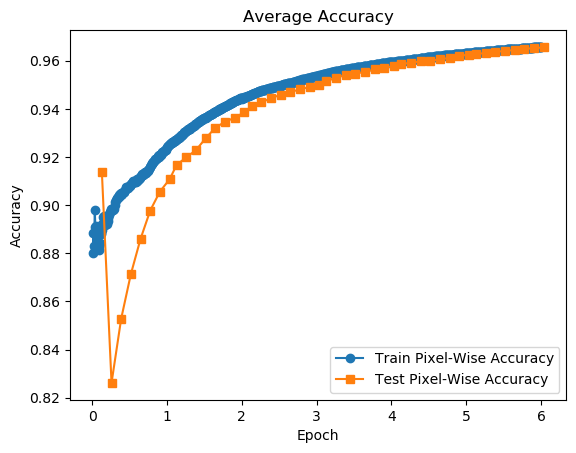

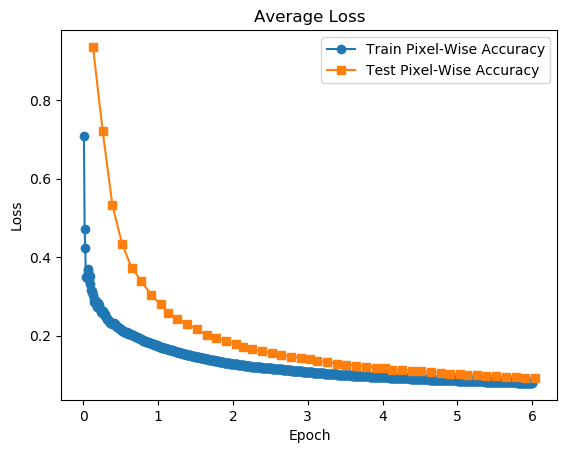

In [16]:
plt.plot(total_updater.train_epoch, total_updater.train_avr_acc, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_acc, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Average Accuracy')

plt.legend()
plt.show()


plt.plot(total_updater.train_epoch, total_updater.train_avr_loss, label='Train Pixel-Wise Accuracy', marker='o', linestyle='-')
plt.plot(total_updater.test_epoch, total_updater.test_avr_loss, label='Test Pixel-Wise Accuracy', marker='s', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss')

plt.legend()
plt.show()

In [17]:
total_updater.test_avr_acc_epoch

[0.9107306003570557,
 0.9665033450493445,
 0.9727036952972412,
 0.9811187707460843,
 0.9816960554856521,
 0.9803588390350342]

Hugging Face Upload

In [18]:
# model.save_pretrained("segformer-b5-finetuned-mangrove-128-128") #save weights to folder

In [19]:
# model.save_model("./my_model")

# with open('auth_token.txt', 'r') as file:
#     auth_token = file.read().strip()

# model.save_model("mpham8/segformer-b5-finetuned-mangrove-128-128", use_auth_token=auth_token)

Inference

In [43]:
next_test_batch = next(test_batch)
test_pixel_values = next_test_batch[0].to(device)
test_labels = next_test_batch[1].to(device)
test_outputs = model(pixel_values=test_pixel_values, labels=test_labels)
test_upsampled_logits = nn.functional.interpolate(test_outputs.logits, size=test_labels.shape[-2:], mode="bilinear", align_corners=False)
test_predicted = test_upsampled_logits.argmax(dim=1)
test_mask = (test_labels != -1) # don't include the background class in the accuracy calculation
test_pred_labels = test_predicted[test_mask].detach().cpu().numpy()
test_true_labels = test_labels[test_mask].detach().cpu().numpy()
test_accuracy = accuracy_score(test_pred_labels, test_true_labels)

In [52]:
reshaped_true = test_true_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
reshaped_pred = test_pred_labels.reshape(BATCH_SIZE, INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)
rgb_pixels = test_pixel_values.detach().cpu().numpy()[:, 0:3,:,:]
rgb_pixels = rearrange(rgb_pixels, "b c w h -> b w h c")


rgb_pixels[0].shape


(128, 128, 3)

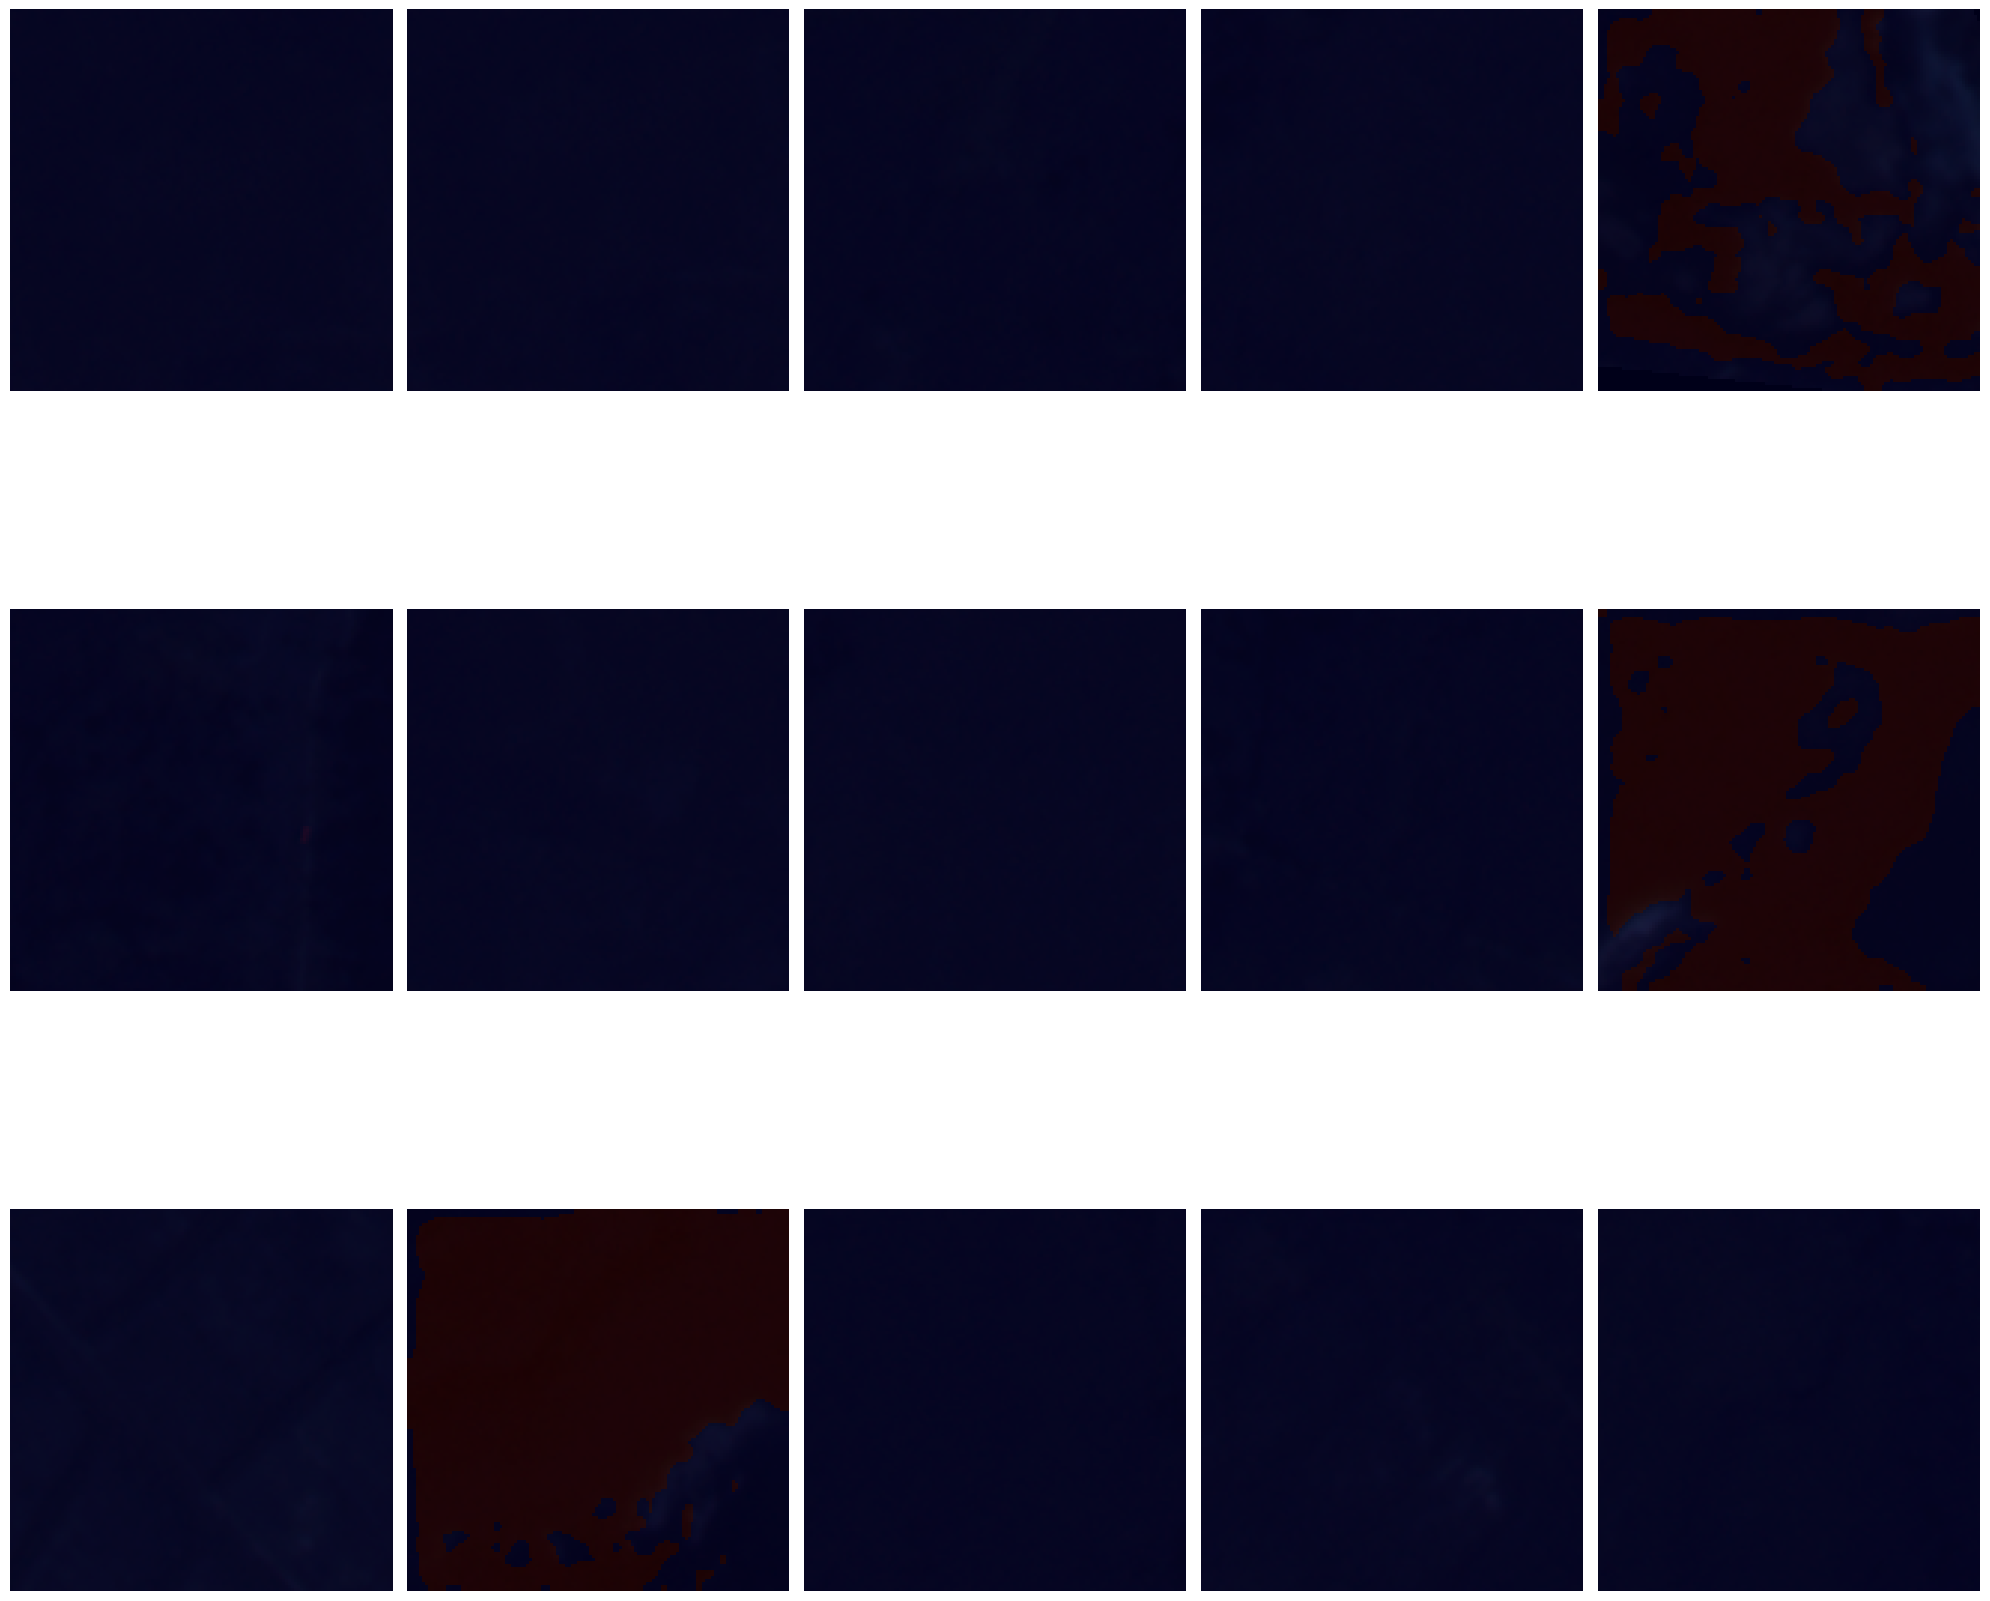

In [53]:
num_rows = 3
num_cols = 5

# Create a new figure with multiple subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))

# Loop through the images and masks and display them in the subplots
for i in range(15):
    img = rgb_pixels[i]
    mask = reshaped_pred[i]

    # Plot the image
    axes[i // num_cols, i % num_cols].imshow(img)

    # Overlay the mask on the image with transparency (alpha value)
    # If the mask is binary (0 and 1), you can set alpha=0.5 to make the mask semi-transparent
    axes[i // num_cols, i % num_cols].imshow(mask, alpha=0.5, cmap='jet')

    # Turn off axis ticks and labels for cleaner visualization
    axes[i // num_cols, i % num_cols].axis('off')

# Display the subplots
plt.tight_layout()
plt.show()